In [1]:
import jax.numpy as jnp
import numpy as np

from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import hj_reachability as hj

from dyn_sys.MzNonlinearCar import MzNonlinearCar


In [2]:
dynamics = MzNonlinearCar()

# limits of the grid in degrees
x1_lim = 150
x2_lim = 60

x1_lim = x1_lim * jnp.pi / 180
x2_lim = x2_lim * jnp.pi / 180

grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(np.array([-x1_lim, -x2_lim]),
                                                                           np.array([x1_lim, x2_lim])),
                                                                           (500, 500))
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 5 * jnp.pi / 180  # radius in radians

time = 0.
target_time = -0.5

In [3]:
target_values = hj.step(solver_settings, dynamics, grid, time, values, target_time)

100%|##########|  0.5000/0.5 [00:00<00:00,  1.85s/sim_s]


<Figure size 640x480 with 0 Axes>

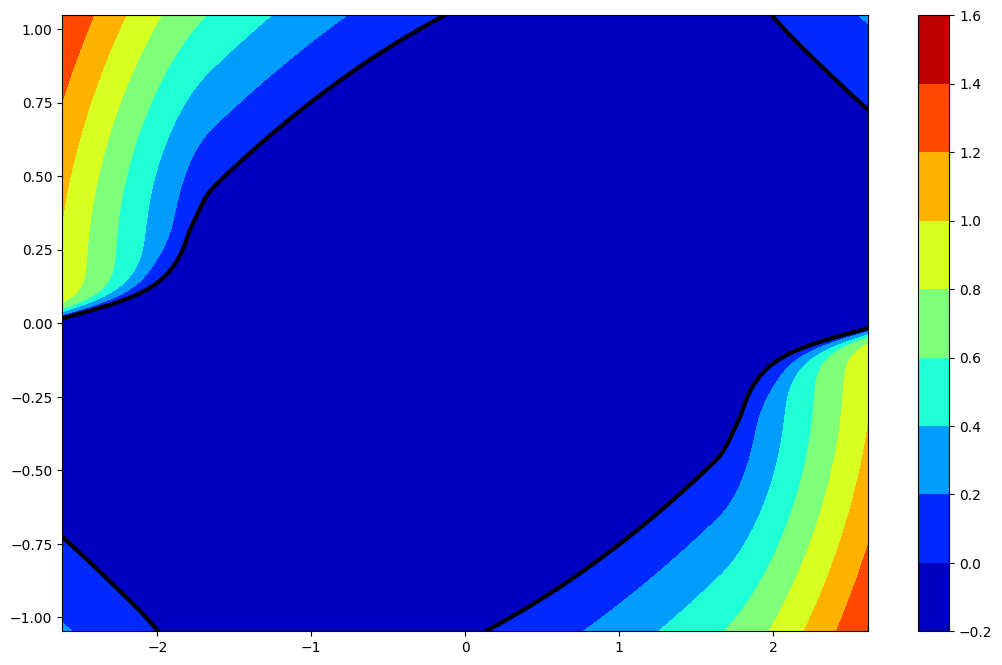

In [4]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :].T,
            levels=0,
            colors="black",
            linewidths=3)